# Cals lstm seqtoseq test
Use a lstm seq to seq tensorflow model to train a network to predict time series outputs.

In [1]:
## The test data



In [2]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy

In [10]:
input_seq_len = 30
output_seq_len = 30

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

def true_signal(x):
    y = 2 * np.sin(x) + 3* np.cos(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x):
    return true_signal(x) + noise_func(x)

def generate_train_samples(x = train_data_x, batch_size = 10, 
                           input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    #print("total_start_points = ", total_start_points)
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    #print("start_x_idx = ", start_x_idx)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x) for x in input_seq_x]
    output_seq_y = [generate_y_values(x) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)


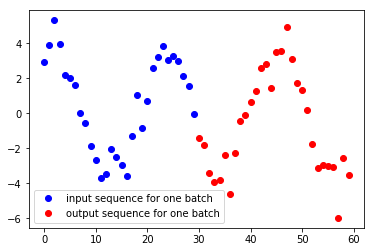

In [11]:
input_seq, output_seq = generate_train_samples(batch_size=10)

l1, = plt.plot(range(30), input_seq[1], 'bo', label = 'input sequence for one batch')
l2, = plt.plot(range(30, 60), output_seq[1], 'ro', label = 'output sequence for one batch')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()